## Tarea 3 - Física Computacional
**Román Tamez Vidal Tamayo Tamez** - (tamoaltas)

In [1]:
import math as m
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [2]:
import matplotlib
# Para el formato de las gráficas
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
        "font.size": 12,
        "pgf.preamble": "\n".join([ # Aún más formato
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        ])
    }
)

### Problema 1:
Implementación de métodos de integración

Realice un notebook en el que se expliquen y programen los siguientes algoritmos de integración de ecuaciones diferenciales:

- **Método de Euler**
- **Serie de Taylor de segundo orden**
- **Runge-Kutta de segundo orden**
- **Runge-Kutta de cuarto orden**

Verifique el funcionamiento de sus integradores encontrando la solución de la siguiente ecuación diferencial para $ x(t) $:

$$
\ddot{x} + 0.5 \dot{x} + \sin x = e^{-t} (\sin(3t) + \cos(2t))
$$

Con condiciones iniciales $ \dot{x}(0) = 1 $ y $ x(0) = 0 $.

El jacobiano del sistema es:
$$
\mathbb{J} = \left( \begin{array}{c c}
0 & 1 \\
-\cos{(x)} & -0.5
\end{array}\right)
$$

In [3]:
def edo_1(t, y):
    # y = [x, v] donde v = dx/dt
    x, v = y
    dvdt = -0.5 * v - np.sin(x) + np.exp(-t) * (np.sin(3*t) + np.cos(2*t))
    return np.array([v, dvdt])

J_1 = np.zeros((2,2))
J_1[0,1], J_1[1,1] = 1, -0.5
def jacob_1(y):
    x, v = y
    J_1[1,0] = -np.cos(x)
    return J_1

#### Método de Euler
El método de Euler aproxima la curva de la solución de una EDO a partir de la pendiente de la recta tangente al punto anterior. 
$$
\frac{d\vec x}{dt} = \vec g(\vec x,t)
$$

$$
\vec x_{n+1} = \vec{x}_n +\delta\vec{g}(\vec{x}_n,t_n)
$$

In [4]:
def integrar_euler(f, t0, y0, tf, h):
    """
    Integra la EDO usando el método de Euler.
    f: función que define el sistema
    t0: tiempo inicial
    y0: condiciones iniciales
    tf: tiempo final
    h: tamaño de paso
    """
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = y_values[i-1] + h*f(t_values[i-1], y_values[i-1])
    
    return t_values, y_values

#### Método de Taylor
El método de Taylor hace lo mismo que el de Euler, pero es más preciso porque utiliza el siguiente término en la expansión de Taylor. 

$$
\vec x_{n+1} = \vec x_n + \delta \vec g(\vec x_n,t_n) +\frac{\delta ^2}{2} \mathbb{J}(\vec x_n,t_n) \cdot \vec g(\vec x_n,t_n)
$$

In [5]:
def integrar_taylor(f,jacob, t0, y0, tf, h):
    """
    Integra la EDO usando el método de Taylor.
    jacob: jacobiana del sistema
    """
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0
    
    for i in range(1, len(t_values)):
        eval_edo = f(t_values[i-1], y_values[i-1]) # Se calculan [x, v]
        y_values[i] = y_values[i-1] + h*eval_edo + 0.5 * h**2 * np.dot(jacob(y_values[i-1]),eval_edo)
    
    return t_values, y_values

#### Método de Runge-Kutta de segundo orde
Los métodos de Runge-Kutta promedian las pendientes de los puntos medios que se obtendrían usando Euler.

$$
\vec x_{n+1} = \vec x_n + \delta \vec g \left( \vec x_{n} + \frac{\delta}{2} \vec k_1,t_n +\frac{\delta}{2} \right) \\
\vec k_1 = \vec g (\vec x_{n},t_{n})
$$

In [6]:
def integrar_RK2(f, t0, y0, tf, h):
    """
    Integra la EDO usando el método de Runge-Kutta de segundo orden.
    """
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        t, y = t_values[i-1], y_values[i-1]
        # Kuttas
        k1 = f(t, y)
        # Runges
        y_values[i] = y + h*f(t+h/2 ,y + (h/2)*k1)

    return t_values, y_values

#### Método de Runge-Kutta de cuarto orden
Las pendientes se van a promediar se muestran a continuación.
$$
\begin{equation}
\begin{aligned}
    \vec x_{n+1} &= \vec x_{n} + \frac{1}{6}\delta (k_1 + 2k_2 + 2k_3 +k_4) \\
    \vec k_1 &= \vec g\left( \vec x_n , t_n \right) & \vec k_2 &= \vec g\left( \vec x_n + \delta \frac{\vec k_1}{2}, t_n +\frac{\delta}{2} \right) \\
    \vec k_3 &= \vec g\left( \vec x_n + \delta \frac{\vec k_2}{2}, t_n +\frac{\delta}{2} \right) & \vec k_4 &= \vec g\left( \vec x_n + \delta \vec k_3, t_n +\delta\right)\\
\end{aligned}
\end{equation}
$$

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7e/Runge-Kutta_slopes.svg" alt="Pendientes utilizadas por el método Runge-Kutta clásico (rk4)" width="500"/>

De <a href="//commons.wikimedia.org/w/index.php?title=User:HilberTraum&amp;action=edit&amp;redlink=1" class="new" title="User:HilberTraum (page does not exist)">HilberTraum</a> - <span class="int-own-work" lang="en">Trabajo propio</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=64366870">Liga</a>

In [7]:
def integrar_RK4(f, t0, y0, tf, h):
    """
    Integra la EDO usando el método de Runge-Kutta de cuarto orden.
    """
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0

    for i in range(1, len(t_values)):
        t, y = t_values[i-1], y_values[i-1]
        # Kuttas
        k1 = f(t        , y)
        k2 = f(t + 0.5*h, y + 0.5*h*k1)
        k3 = f(t + 0.5*h, y + 0.5*h*k2)
        k4 = f(t +     h, y +     h*k3)
        # Runges
        y_values[i] = y + h*f(t+h/2 ,y + (h/6)*(k1+2*k2+2*k3+k4))

    return t_values, y_values

In [8]:
# Condiciones iniciales
t0, tf = 0, 10  # Tiempo inicial y final
h = 0.05  # Paso de tiempo
y0 = np.array([0, 1])  # x(0) = 0, v(0) = 1

# Integración
t_values_a, y_values_a = integrar_euler(edo_1, t0, y0, tf, h)
t_values_b, y_values_b = integrar_taylor(edo_1, jacob_1,t0, y0, tf, h)
t_values_c, y_values_c = integrar_RK2(edo_1,t0, y0, tf, h)
t_values_d, y_values_d = integrar_RK4(edo_1,t0, y0, tf, h)

#### Graficas

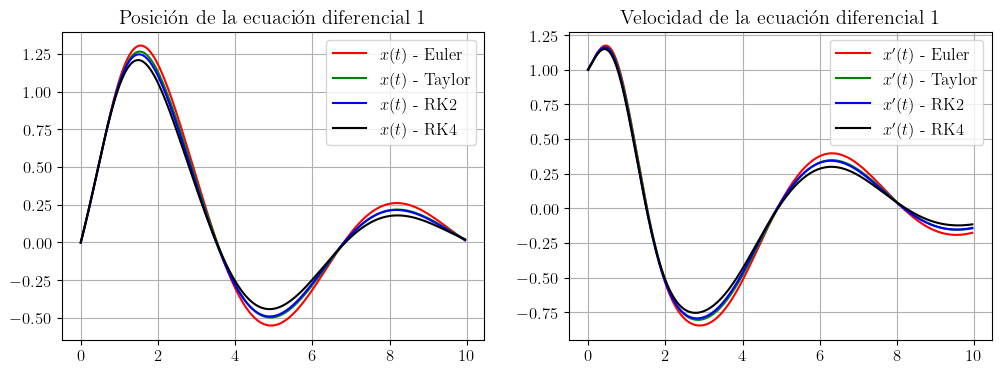

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t_values_a, y_values_a[:, 0], label=r'$x(t)$ - Euler', color='r')
axes[0].plot(t_values_b, y_values_b[:, 0], label=r'$x(t)$ - Taylor', color='g')
axes[0].plot(t_values_c, y_values_c[:, 0], label=r'$x(t)$ - RK2', color='b')
axes[0].plot(t_values_d, y_values_d[:, 0], label=r'$x(t)$ - RK4', color='k')
axes[0].legend(), axes[0].grid()
axes[0].set_title('Posición de la ecuación diferencial 1')

axes[1].plot(t_values_a, y_values_a[:, 1], label=r"$x'(t)$ - Euler", color='r')
axes[1].plot(t_values_b, y_values_b[:, 1], label=r"$x'(t)$ - Taylor", color='g')
axes[1].plot(t_values_c, y_values_c[:, 1], label=r"$x'(t)$ - RK2", color='b')
axes[1].plot(t_values_d, y_values_d[:, 1], label=r"$x'(t)$ - RK4", color='k')
axes[1].legend(), axes[1].grid()
axes[1].set_title('Velocidad de la ecuación diferencial 1')

plt.show()

### Problema 2:


Utilizando los integradores anteriores, encuentre un paso que asegure que la solución tenga por lo menos 4 cifras significativas en el resultado de integración. La ecuación diferencial es la siguiente:

$$ 
\dddot y + \ddot{y}^2 - 3\dot{y}^3 + \cos^2 y = e^{-t} \sin(3t) 
$$

Con condiciones iniciales $ \ddot{y}(1) = 1, \quad \dot{y}(1) = 2, \quad y(1) = 1 $. En particular, describa lo que sucede en el intervalo $t \in [1, 1.65] $ y analice el comportamiento cuando $t \to 2$.


In [10]:
def edo_2(t, y):
    # y = [x, v, a] donde v = dx/dt, a = dv/dt
    x, v, a = y
    dadt = -a**2 + 3*v**3 - np.cos(x)**2 + np.exp(-t) * np.sin(3*t)
    return np.array([v, a, dadt])

#### Buscador de $h$

In [11]:
def checar_cifras_o_diff(a,b,n=4):
    '''
    Checa si dos números coinciden en las primeras n cifras o
    si su diferencia es menor a 1e-n
    '''
    diff = abs(a-b)
    return (diff/(a+1e-20) <= 10**(-n) or diff <= 10**(-n))

def comp_elementos(a, b, comp_func):
    '''
    Compara 1 a 1 los elementos a[i][j], b[i][j] con una función 
    de comparación dada

    Regresa 'True' si todo elemento cumple con la condición y 'False' si no.
    '''
    for i in range(min(len(a),len(b))):
        for (val_a, val_b) in zip(a[i], b[i]):
            if not comp_func(val_a, val_b): 
                return False
    return True

In [12]:
def obtener_h_integrador(inter, comp_func, h0):
    """
    Obtiene una h de forma que las soluciones de un integrador con paso
    h/2 y uno con paso h coincidan según una función de comparación
    'comp_func'.
    inter: función del integrador que toma como argumento h
    comp_func: función de comparación
    h0: primer valor a tratar de h
    """
    t_old, y_old = inter(h0)
    h = h0*0.5
    
    for i in range(1, 100):
        if h < 1e-8:
            break # Salida por si acaso

        print('Paso:',i,'\t h:', h)
        t, y = inter(h)

        # Se transponen las soluciones obtenidas por el integrador
        sols_old = [col for col in y_old.T]
        sols = [col[0::2] for col in y.T] # Se toman valores cada dos puntos
        # print(len(sols_old[0]), len(sols[0]))
        if comp_elementos(sols_old, sols, comp_func): return t, y, h
            
        h = h*0.5
        y_old = y
        
    print('Algo salió mal.')
    return None, None, None

#### Soluciones de la segunda ec. diferencial

In [13]:
t0, tf = 1,1.65 # Tiempo inicial y final
y0 = np.array([1, 2, 1])  # x(1) = 1, v(1) = 2, a(1) = 1

t_2, y_2, h_2 = obtener_h_integrador(lambda h: integrar_RK4(edo_2,t0, y0, tf, h), checar_cifras_o_diff, 0.1)

Paso: 1 	 h: 0.05
Paso: 2 	 h: 0.025
Paso: 3 	 h: 0.0125
Paso: 4 	 h: 0.00625
Paso: 5 	 h: 0.003125
Paso: 6 	 h: 0.0015625
Paso: 7 	 h: 0.00078125
Paso: 8 	 h: 0.000390625
Paso: 9 	 h: 0.0001953125
Paso: 10 	 h: 9.765625e-05
Paso: 11 	 h: 4.8828125e-05
Paso: 12 	 h: 2.44140625e-05
Paso: 13 	 h: 1.220703125e-05
Paso: 14 	 h: 6.103515625e-06
Paso: 15 	 h: 3.0517578125e-06


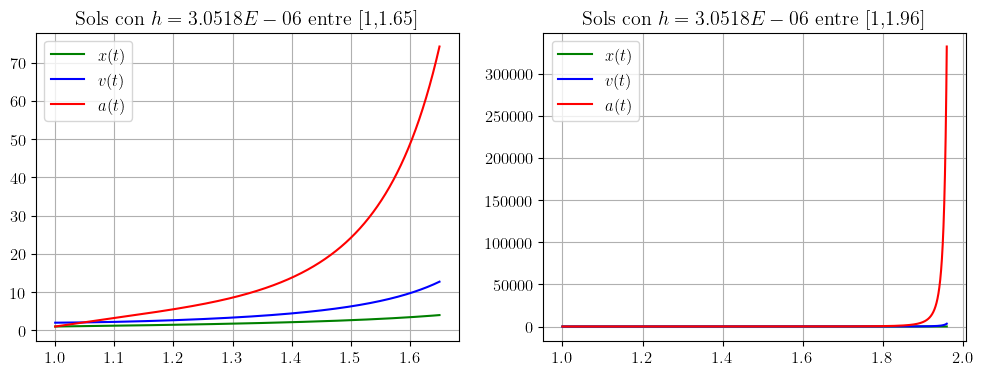

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t_2, y_2[:, 0], label=r'$x(t)$', color='g')
axes[0].plot(t_2, y_2[:, 1], label=r'$v(t)$', color='b')
axes[0].plot(t_2, y_2[:, 2], label=r'$a(t)$', color='r')
axes[0].legend(), axes[0].grid()
axes[0].set_title('Sols con $h={:.4E}$ entre [{},{}]'.format(h_2,t0,tf))

t0, tf = 1,1.96 # Tiempo inicial y final
t_2a, y_2a = integrar_RK4(edo_2,t0, y0, tf, h_2)

axes[1].plot(t_2a, y_2a[:, 0], label=r'$x(t)$', color='g')
axes[1].plot(t_2a, y_2a[:, 1], label=r'$v(t)$', color='b')
axes[1].plot(t_2a, y_2a[:, 2], label=r'$a(t)$', color='r')
axes[1].legend(), axes[1].grid()
axes[1].set_title('Sols con $h={:.4E}$ entre [{},{}]'.format(h_2,t0,tf))

plt.show()

La aceleración se vuelve muy grande conforme $t \to 2$, lo que apunta a cambios muy repentinos en la velocidad y por ende en la posición.

### Problema 3
Modifique las funciones integradoras del Problema 1 para que puedan aceptar argumentos opcionales en el sistema de ecuaciones diferenciales, permitiendo modificar parámetros al momento de hacer la integración. Una vez hecho esto, obtenga la solución de la siguiente ecuación diferencial:

$$ 
\ddot{x} + \frac{1}{10} \dot{x} + 4 \sin x = \frac{1}{2} \sin(\omega t) 
$$

Con condiciones iniciales $\dot{x}(0) = 1, \quad x(0) = 0$ y para $\omega = \{1, 1.1, 1.2, 1.3, \dots, 2.9, 3\}$. Realice la gráfica de algunas soluciones que representen el comportamiento de la solución en función de $\omega$ y explique su resultado.

El jacobiano del sistema es:
$$
\mathbb{J} = \left( \begin{array}{c c}
0 & 1 \\
-4 \cos{(x)} & -1/10
\end{array}\right)
$$

In [15]:
def edo_3(t, y, omega):
    # y = [x, v] donde v = dx/dt
    x, v = y
    dvdt = -0.1 * v - 4 * np.sin(x) + 0.5 * np.sin(omega*t)
    return np.array([v, dvdt])

J_3 = np.zeros((2,2))
J_3[0,1], J_3[1,1] = 1, -0.1
def jacob_1(y):
    x, v = y
    J_3[1,0] = -4*np.cos(x)
    return J_3

In [16]:
t0, tf = 0,100 # Tiempo inicial y final
h = 0.05  # Paso de tiempo
y0 = np.array([0, 1])  # x(0) = 0, v(0) = 1
omegas = np.arange(1,3.01,0.3)
print(omegas)
sols = [integrar_RK4(lambda t, y: edo_3(t,y,omg), t0, y0, tf, h) for omg in omegas]


[1.  1.3 1.6 1.9 2.2 2.5 2.8]


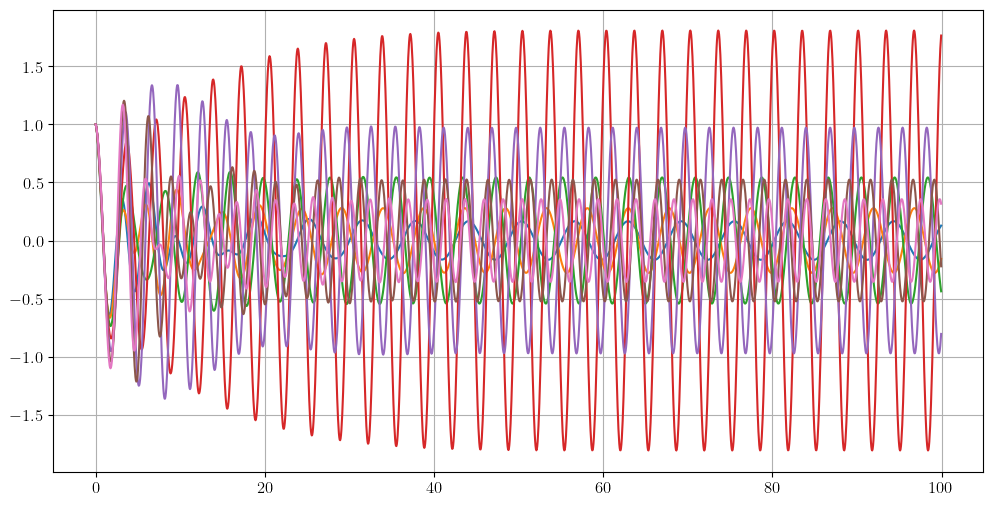

In [17]:
plt.figure(figsize=(12,6))
for i in range(len(sols)):
    t, y = sols[i]
    plt.plot(t, y[:,1])
    
plt.grid()
plt.show()

### Problema 4
Considere el siguiente sistema de ecuaciones diferenciales:

$$
\frac{dx}{dt} = 10(y - x)
$$

$$
\frac{dy}{dt} = x(28 - z) - y
$$

$$
\frac{dz}{dt} = xy - \frac{8}{3}z
$$

Realice una integración numérica del sistema con alguno de los integradores del Problema 1 y realice los siguientes ejercicios:

1. Elija una condición inicial aleatoria en $ x, y, z \in [-5, 5] $ y realice la gráfica de la solución en los planos $xy$, $xz$ y $yz$. Comente sus observaciones.
2. Proponga 3 condiciones iniciales donde solo la coordenada $y$ difiera en $10^{-2}$. Explique lo que observa.

**Nota**: De preferencia realice integraciones con tiempos relativamente largos para apreciar diferencias en el comportamiento de las soluciones. Asegure que cada solución sea convergente, encontrando un paso adecuado para la integración.


In [18]:
def edo_4(t, r):
    x, y, z = r
    dxdt = 10*(y - x)
    dydt = x*(28 - z) - y
    dzdt = x*y - (8.0/3.0)*z
    return np.array([dxdt, dydt, dzdt])

In [56]:
t0, tf = -30, 30
h = 0.001
y0 = np.array([1, -1,2]) # Puntos iniciales

t, sols = integrar_RK4(edo_4,t0, y0, tf, h)

#### Parte 1

-5.2375989636991065
-8.247304069851198
17.045997980549217


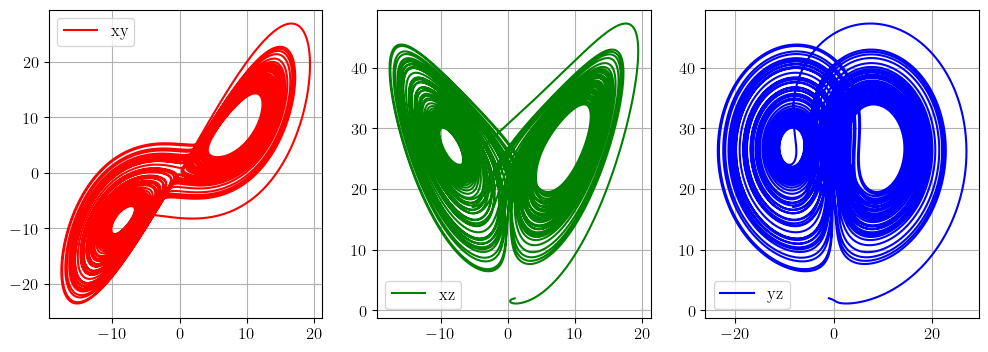

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

print(sols[-1,0])
print(sols[-1,1])
print(sols[-1,2])

axes[0].plot(sols[:, 0], sols[:, 1], color='r', label='xy')
axes[0].legend(), axes[0].grid()
axes[1].plot(sols[:, 0], sols[:, 2], color='g', label='xz')
axes[1].legend(), axes[1].grid()
axes[2].plot(sols[:, 1], sols[:, 2], color='b', label='yz')
axes[2].legend(), axes[2].grid()

plt.show()

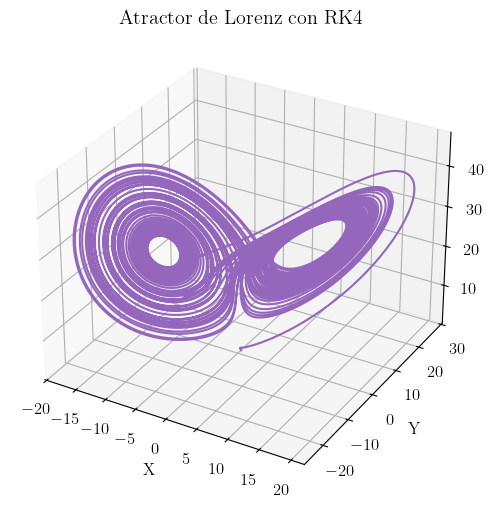

In [60]:
# Graficar la trayectoria
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sols[:, 0], sols[:, 1], sols[:, 2], color='tab:purple')
ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
ax.set_title("Atractor de Lorenz con RK4")
plt.show()

In [52]:
y0s = [
    np.array([1, 3.01,-2]),
    np.array([1, 2.99,-2]),
    np.array([1, 3.00,-2])
] # Puntos iniciales

sols = [integrar_RK4(edo_4, t0, ini, tf, h) for ini in y0s]

#### Parte 2

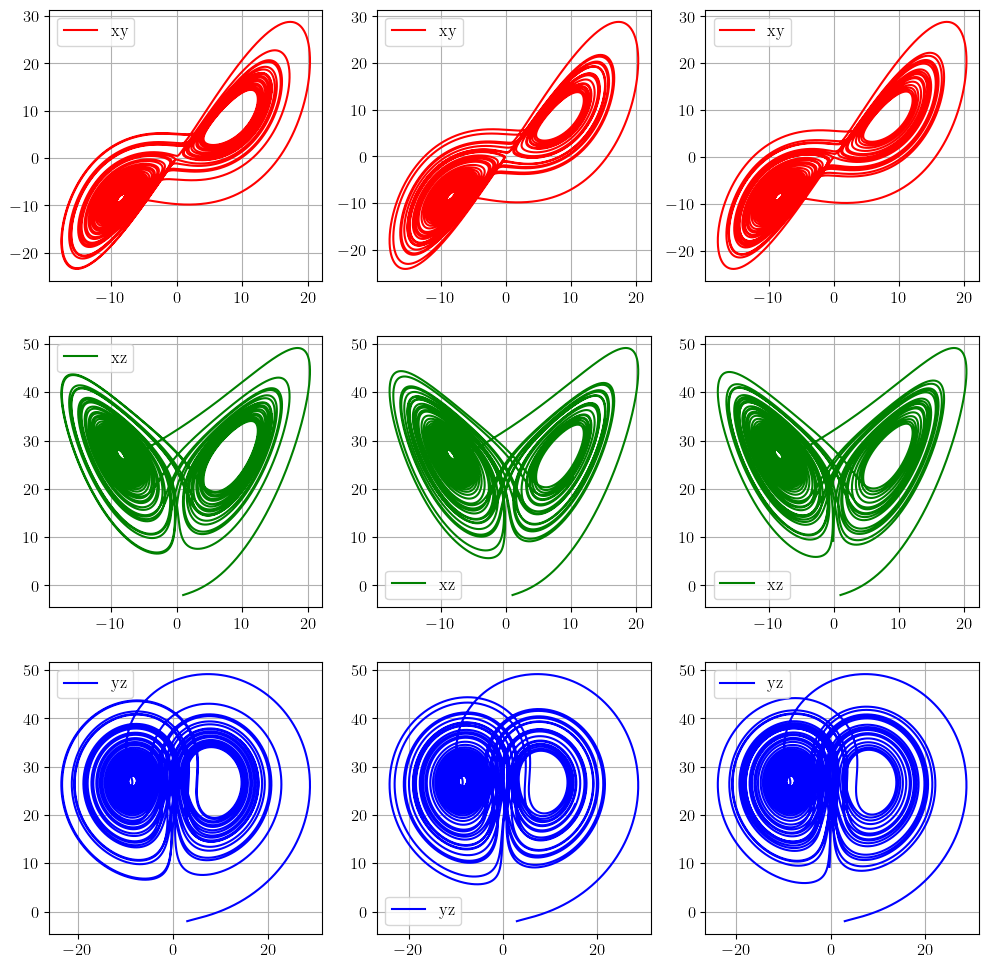

In [ ]:
info = [
    [[0,1], 'r', 'xy'],
    [[0,2], 'g', 'xz'],
    [[1,2], 'b', 'yz']
]

# Graficas
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(len(sols)):
    t, sol = sols[i]

    for j in range(len(info)):
        row = info[j]
        axes[j,i].plot(sol[:, row[0][0]], sol[:, row[0][1]], color=row[1], label=row[2])
        axes[j,i].legend(), axes[j,i].grid()

plt.show()


print(sols[-1,0])
print(sols[-1,1])
print(sols[-1,2])
